In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:09<00:00, 281MB/s]
100% 2.29G/2.29G [00:09<00:00, 263MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-04

In [ ]:
!git clone https://github.com/ieee8023/COVID-chestxray-dataset

Cloning into 'COVID-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 40.07 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Checking out files: 100% (1174/1174), done.


In [ ]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import  EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import glob as gb
import argparse
import cv2


In [ ]:
 print(tf.__version__) 

2.8.2


In [ ]:
trainpath = "/content/chest_xray/train"
in_fpath2 = "/content/COVID-chestxray-dataset"
csvFilePath = "/content/COVID-chestxray-dataset/metadata.csv"

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
Ext = ['jpg', 'jpeg','png']
data = []
labels = []

In [ ]:

#Open Folders
#now let's first check the Train folder to have a look to its content

for folder in  os.listdir(trainpath) :
    file_list = []
    n=0 #take 1100 images per class
    for extension in Ext:
        #print(folder)
        file_list.extend(gb.glob(pathname= str( trainpath +'//' + folder + '/*.' + extension)))
        #print(files)
        #print(f'For training data , found {len(file_list)} in folder {folder}')
    print(f'For training data , found {len(file_list)} ')    
    for imagePath in file_list:
        if n < 1000:
          # extract the class label from the filename
          label = imagePath.split(os.path.sep)[-2]
          # load the image, swap color channels, and resize it to be a fixed
          # 224x224 pixels while ignoring aspect ratio
          image = cv2.imread(imagePath)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = cv2.resize(image, (224, 224))
          # update the data and labels lists, respectively
          data.append(image)
          labels.append(folder)
          n +=1
        else:
          break

For training data , found 3875 
For training data , found 1341 


In [ ]:
print(len(data))

2000


In [ ]:
# here we would like to only keep rows where RT_PCR_positive column values are equal  "Y"
df = pd.read_csv(csvFilePath,delimiter=',')

print(df['RT_PCR_positive'].size)

# Find unique values of a column
print(df['RT_PCR_positive'].unique())

# drop rows with NaN value
#df.dropna(subset = ["RT_PCR_positive"], inplace=True)

# keep rows with 'Y' value
df = df[df["RT_PCR_positive"] == "Y"]

print(df['RT_PCR_positive'].size)
print(df['RT_PCR_positive'].unique())



950
['Y' nan 'Unclear']
371
['Y']


In [ ]:
# this function returns 10 first rows
df.head(10)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN
5,4,5.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 30, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1b.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive diffuse interstitial opacities and...,NaN,NaN
7,6,0.0,NaN,NaN,Pneumonia/Viral/COVID-19,Y,NaN,Y,Y,Y,...,"January 6, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2a.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN
8,6,4.0,NaN,NaN,Pneumonia/Viral/COVID-19,Y,NaN,Y,Y,Y,...,"January 10, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2b.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN
20,11,0.0,M,56.0,Pneumonia/Viral/COVID-19,Y,Y,NaN,NaN,NaN,...,2020,"Sunnybrook Health Sciences Centre, Toronto, On...",images,1-s2.0-S0140673620303706-fx1_lrg.jpg,10.1016/S0140-6736(20)30370-6,https://www.sciencedirect.com/science/article/...,NaN,A 56-year-old man presented to our Emergency D...,NaN,NaN
21,12,7.0,M,42.0,Pneumonia/Viral/COVID-19,Y,Y,NaN,NaN,NaN,...,"January 1, 2020","Tongji Medical College, Wuhan, Hubei Province,...",images,nCoV-radiol.2020200269.fig1-day7.jpeg,10.1148/radiol.2020200269,https://pubs.rsna.org/doi/10.1148/radiol.20202...,NaN,"On January 1, 2020, a 42-year-old man was admi...",NaN,NaN


In [ ]:

#Open Folders
#now let's first check the Train folder to have a look to its content
file_list = []
for index, row in df.iterrows():
  #print(row['RT_PCR_positive'])
  file_list.extend(gb.glob(pathname= str( in_fpath2 +'//' + row['folder'] + '//'+row['filename'])))
print(f'For training data , found {len(file_list)} ')
for imagePath in file_list:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append("COVID")


For training data , found 362 


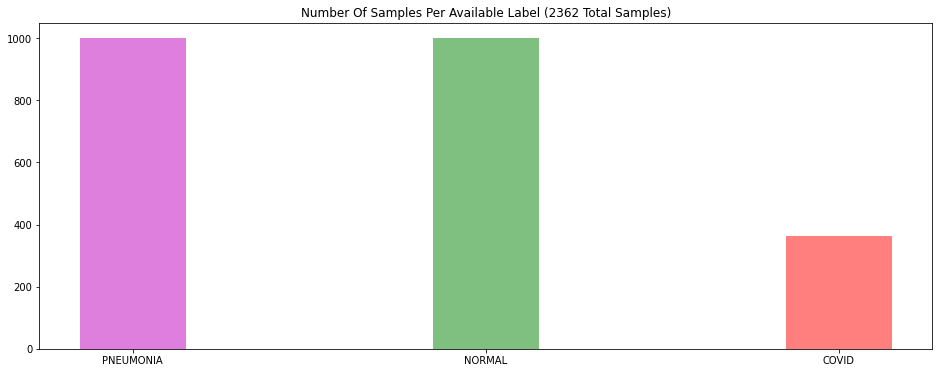

In [ ]:
# Plot a bar with numbers of normal , pneumonia and covid diagnoses
fig = plt.figure(figsize=(16, 6))
#ax = fig.add_axes([0,0,1,1])
keys = Counter(labels).keys() # equals to list(set(words))
values = Counter(labels).values() # counts the elements' frequency
plt.bar(keys,values,width=0.3,color=['m', 'g','r'],alpha=.5)
plt.title('Number Of Samples Per Available Label ({0:d} Total Samples)'.
          format(len(labels)))
plt.show() 

In [ ]:
# numbers of normal , pneumonia and covid diagnoses
values = list(Counter(labels).values())
print(values)
# how many images we should add to Handle Imbalanced Data
print(values[0]-values[2]) 


[1000, 1000, 362]
638


In [ ]:
# Data augmentation technique
data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2),
     layers.experimental.preprocessing.RandomZoom(.1, .2)])
'''
plt.figure(figsize=(10, 10))
#image = tf.expand_dims(data[1], 0)
image = tf.cast(tf.expand_dims(data[1], 0), tf.int32)
for i in range(4):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")
'''

'\nplt.figure(figsize=(10, 10))\n#image = tf.expand_dims(data[1], 0)\nimage = tf.cast(tf.expand_dims(data[1], 0), tf.int32)\nfor i in range(4):\n  augmented_image = data_augmentation(image)\n  ax = plt.subplot(2, 2, i + 1)\n  plt.imshow(augmented_image[0])\n  plt.axis("off")\n'

In [ ]:
# We apply data augmentation technique only on the covid set.
labels.index("COVID")
for i in range(labels.index("COVID"),labels.index("COVID")+(values[0]-values[2])):
  image = tf.expand_dims(data[i], 0)
  augmented_image = data_augmentation(image)
  # update the data and labels lists, respectively
  data.append(augmented_image[0])
  labels.append("COVID")

[1000, 1000, 1000]


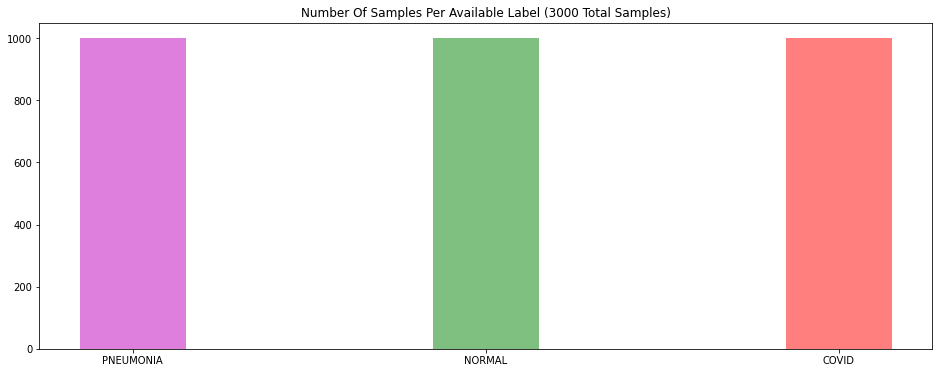

In [ ]:
values = list(Counter(labels).values())
print(values)
# Plot a bar with numbers of normal , pneumonia and covid diagnoses after data augmentation 
fig = plt.figure(figsize=(16, 6))
#ax = fig.add_axes([0,0,1,1])
keys = Counter(labels).keys() # equals to list(set(words))
values = Counter(labels).values() # counts the elements' frequency
plt.bar(keys,values,width=0.3,color=['m', 'g','r'],alpha=.5)
plt.title('Number Of Samples Per Available Label ({0:d} Total Samples)'.
          format(len(labels)))
plt.show() 

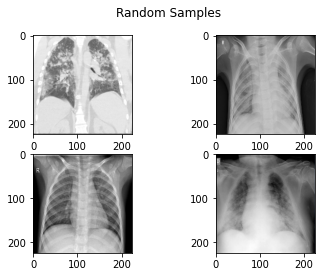

In [ ]:
#random sample
# Build a 2 x 2 figure
rows, columns = 2, 2
fig, axes = plt.subplots(rows, columns)

# Set figure title
fig.suptitle('Random Samples')

# Plot normal images
for i in range(rows):
    for j in range(columns):
        
        n = np.random.randint(0,len(labels))
        axes[i, j].imshow(data[n])
        
        
plt.show()

In [ ]:
# normalizing data
data = np.array(data) / 255.0
labels = np.array(labels)

In [ ]:
print(data.shape)
print(labels.shape)


(3000, 224, 224, 3)
(3000,)


In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#print(labels.shape)
#labels = to_categorical(labels,num_classes=4)


In [ ]:
print(labels.shape)

(3000, 3)


In [ ]:
# partition the data into training and testing splits using 85% of the data for training and the remaining 15% for testing
# nsamples, nx, ny = labels.shape
# labels_ = labels.reshape(nsamples,nx*ny)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.15, stratify=labels, random_state=42)

In [ ]:
# freeing  memory
data = labels = None

In [ ]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
VggModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
# construct the head of the model that will be placed on top of the base model

_Model = VggModel.output
_Model = MaxPooling2D(pool_size=(4, 4))(_Model)
_Model = Flatten(name="flatten")(_Model)
_Model = Dense(64, activation="relu")(_Model)
_Model = Dense(32, activation="relu")(_Model)
_Model = Dropout(0.5)(_Model)
_Model = Dense(3, activation="softmax")(_Model)
# place the head FC model on top of the base model (this will become the actual model we will train)

model = Model(inputs=VggModel.input, outputs=_Model)
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process

for layer in VggModel.layers:
	layer.trainable = False

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# initialize the initial learning rate, number of epochs to train for, and batch size

INIT_LR = 1e-3  #learning rate
EPOCHS = 120   #number of iterations
BS = 64     #batch size  

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#loss_1 = tf.losses.sparse_softmax_cross_entropy(labels,model.predict(trainX, batch_size=BS))
model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

# train the network
print("[INFO] training network...")
H = model.fit(x=trainX,y=trainY,
	validation_data=(testX, testY),
  batch_size=BS,
	epochs=EPOCHS,
  callbacks=[early_stopping])

	#validation_steps=len(testX) // BS,
	#steps_per_epoch=len(trainX) // BS,
	#trainAug.flow(trainX, trainY, batch_size=BS),

[INFO] compiling model...
[INFO] training network...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/120
40/40 [==============================] - 36s 538ms/step - loss: 0.9332 - accuracy: 0.5737 - val_loss: 0.5658 - val_accuracy: 0.8733
Epoch 2/120
40/40 [==============================] - 14s 355ms/step - loss: 0.5021 - accuracy: 0.8204 - val_loss: 0.3684 - val_accuracy: 0.8867
Epoch 3/120
40/40 [==============================] - 14s 359ms/step - loss: 0.3788 - accuracy: 0.8627 - val_loss: 0.2633 - val_accuracy: 0.9067
Epoch 4/120
40/40 [==============================] - 15s 365ms/step - loss: 0.2907 - accuracy: 0.9000 - val_loss: 0.2414 - val_accuracy: 0.9156
Epoch 5/120
40/40 [==============================] - 15s 378ms/step - loss: 0.2494 - accuracy: 0.9153 - val_loss: 0.2110 - val_accuracy: 0.9244
Epoch 6/120
40/40 [==============================] - 15s 383ms/step - loss: 0.1930 - accuracy: 0.9376 - val_loss: 0.1851 - val_accuracy: 0.9356
Epoch 7/120
40/40 [==============================] - 15s 389ms/step - loss: 0.1797 - accuracy: 0.9404 - val_loss: 0.1947 - val_accuracy:

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(lb.classes_)
#target_names=list(map(str,lb.classes_))
#print(target_names)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
['COVID' 'NORMAL' 'PNEUMONIA']
              precision    recall  f1-score   support

       COVID       0.97      0.97      0.97       150
      NORMAL       0.93      0.98      0.95       150
   PNEUMONIA       0.95      0.90      0.92       150

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)

# show the confusion matrix, accuracy
print(cm)
print("acc: {:.2f}".format(np.trace(cm)/sum(sum(cm))))


[[146   0   4]
 [  0 147   3]
 [  4  11 135]]
acc: 0.95


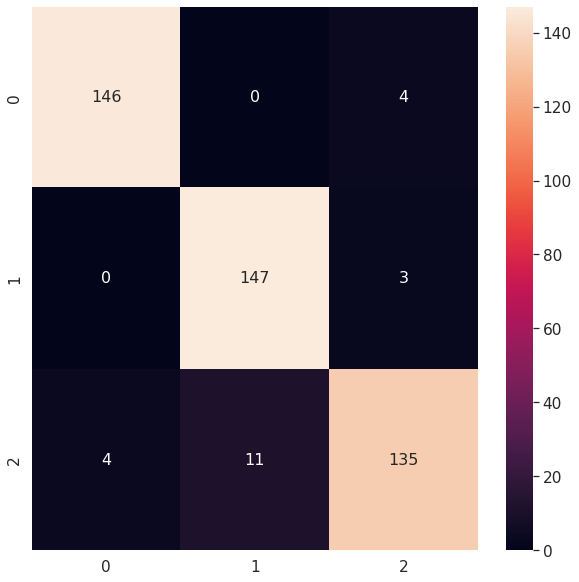

In [ ]:
# plot the confusion matrix
df_cm = pd.DataFrame(cm, range(3), range(3))
plt.figure(figsize=(10,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g') # font size

plt.show()

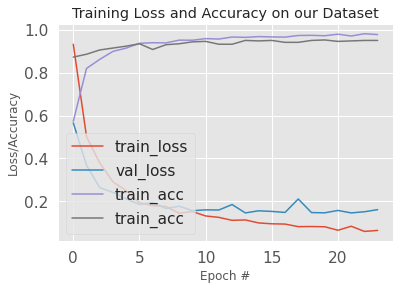

In [ ]:
# plot the training loss and accuracy
N = early_stopping.stopped_epoch +1
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="train_acc")

plt.title("Training Loss and Accuracy on our Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")